In [26]:
import sys
import os 

os.environ["CONFIG_PATHS"] = "../../configs/self_play.yaml"
os.environ["CONFIG_OVERRIDES"] = 'game.moves_directory="../../data/moves_10"'
sys.path.append("../../src")

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import random 

from analysis import load_events, filter_events
from display import Display
from training.load_games import load_games_new

Loaded config:  {"development": {"debug_mode": true, "profile": false, "runtime": 0, "display_logs_in_console": false, "output_directory": "data/2024-11-23_00-37-50-doublehandedness"}, "logging": {"save_interval": 3600, "mcts_report_fraction": 0, "ucb_report": false, "gpu_evaluation": true, "made_move": true}, "game": {"board_size": 10, "num_moves": 6233, "num_pieces": 21, "moves_directory": "../../data/moves_10"}, "architecture": {"gameplay_processes": 6, "coroutines_per_process": 256, "game_flush_threshold": 200}, "training": {"run": true, "network_name": "default", "batch_size": 64, "policy_loss_weight": 0.158, "learning_rate": 0.001, "sample_window": 50000, "samples_per_generation": 10000, "sampling_ratio": 1.0, "minimum_window_size": 10000, "new_data_check_interval": 60}, "networks": {"default": {"main_body_channels": 64, "value_head_channels": 16, "value_head_flat_layer_width": 64, "policy_head_channels": 64, "residual_blocks": 8, "model_path": "", "model_directory": "data/2024-1

In [2]:
events = load_events("../../data/2024-12-01_10-23-12-giant-arena-for-doublehandedness/logs_2024-12-01_13-37-25_798441.txt")

Start time: 1733078217.8078551


In [3]:
for event in events:
    if event.name == "loaded_model":
        print(event.params)

{'model_name': '001005949'}
{'model_name': '000808640'}
{'model_name': '001800050'}
{'model_name': '001400050'}
{'model_name': '001700018'}
{'model_name': '001309389'}
{'model_name': '001204743'}
{'model_name': '000403006'}
{'model_name': '001110265'}
{'model_name': '000204325'}
{'model_name': '001600050'}
{'model_name': '001500018'}
{'model_name': '002000050'}
{'model_name': '001900018'}
{'model_name': '002100018'}
{'model_name': '002190002'}


In [4]:
game_result_events = filter_events(events, "game_result")
game_results = [event.params for event in game_result_events]

# I didn't zfill the player names, so we need to do that now
# for sorting to work.
# for game_result in game_results:
#     for result_line in game_result:
#         result_line[0] = result_line[0][1:].zfill(6)

players = set()
for game_result in game_results:
    for player, _ in game_result:
        players.add(player)

players = sorted(list(players), key=lambda x: int(x))

print(players)
print("Number of games:", len(game_results))

['204325', '403006', '808640', '1005949', '1110265', '1204743', '1309389', '1400050', '1500018', '1600050', '1700018', '1800050', '1900018', '2000050', '2100018', '2190002']
Number of games: 4703


In [5]:
# Do a naive calculation of average performance per game per player.
player_total_scores = {player: 0 for player in players}
player_total_games = {player: 0 for player in players}

for game_result in game_results:
    for player, result in game_result:
        player_total_scores[player] += result
        player_total_games[player] += 1

player_average_scores = {player: player_total_scores[player] / player_total_games[player] for player in players}
player_average_scores

{'204325': 0.12728310502283102,
 '403006': 0.1733507701249637,
 '808640': 0.24322783005417734,
 '1005949': 0.1928386540120794,
 '1110265': 0.24979044425817273,
 '1204743': 0.2649537792278412,
 '1309389': 0.236995753715499,
 '1400050': 0.2336475292773494,
 '1500018': 0.2588803637396988,
 '1600050': 0.29022746419545076,
 '1700018': 0.2760103181427343,
 '1800050': 0.2750631844987363,
 '1900018': 0.28732712390629406,
 '2000050': 0.30143678160919535,
 '2100018': 0.29093309859154937,
 '2190002': 0.2976608187134503}

To use the stuff below, first run enough iterations in the first cell that the elos lines roughly converge. Then, run the bottom cell to generate a plot of the final elos.

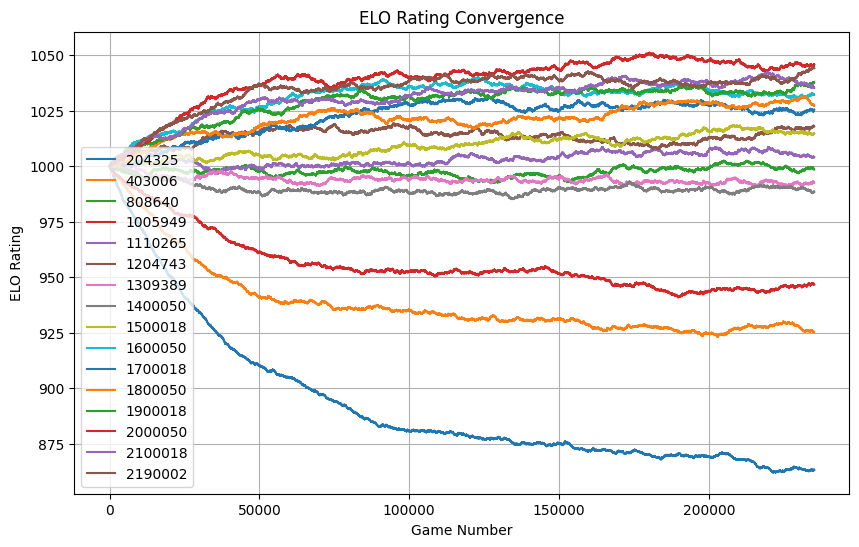

In [6]:
elos = [{player: 1000 for player in players}]

elo_K = 0.1
elo_base = 400.0

for _ in range(len(game_results) * 50):
    game_result = random.choice(game_results)

    latest_elo = elos[-1].copy()

    game_players = [player_name for player_name, _ in game_result]
    Q_player = [10 ** (latest_elo[player] / elo_base) for player in game_players]
    Q_total = sum(Q_player)
    E_player = [Q / Q_total for Q in Q_player]

    for i, (player, result) in enumerate(game_result):
        latest_elo[player] += elo_K * (result - E_player[i])

    elos.append(latest_elo)

# Extract player names from the first dictionary in elos
player_names = elos[0].keys()

# Prepare data for plotting
elo_history = {player: [] for player in player_names}

# Populate elo_history with ELO ratings over time
for elo_snapshot in elos:
    for player in player_names:
        elo_history[player].append(elo_snapshot[player])

# Plot ELO ratings for each player
plt.figure(figsize=(10, 6))
for player, history in elo_history.items():
    plt.plot(history, label=player)

plt.title("ELO Rating Convergence")
plt.xlabel("Game Number")
plt.ylabel("ELO Rating")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

final_elos = elos[-1]

/var/folders/np/v76cnj490z525wk67wqh68dc0000gn/T/ipykernel_44736/2855983713.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


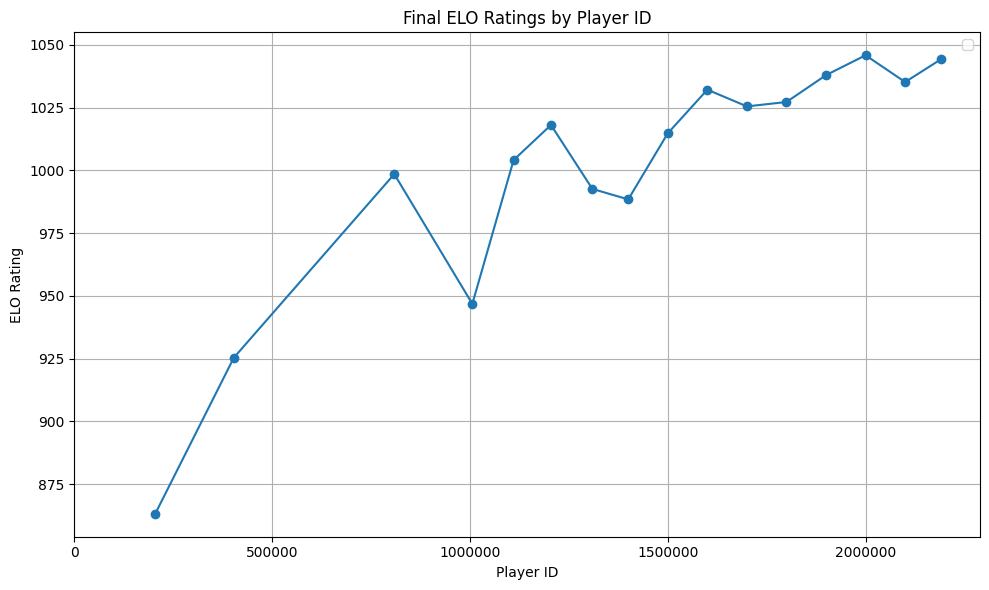

In [7]:
plt.figure(figsize=(10, 6))

# elos_x = {}
# elos_y = {}
# for player in players:
#     category, number_part = player.split("_")
#     number = int(number_part[:-1])

#     elos_x[category] = elos_x.get(category, []) + [number]
#     elos_y[category] = elos_y.get(category, []) + [final_elos[player]]

# plt.plot(elos_x["literatist"], elos_y["literatist"], marker='o', label="Literatist")
# plt.plot(elos_x["doublehandedness"], elos_y["doublehandedness"], marker='o', label="Doublehandedness")

elos_x = [int(player) for player in players]
elos_y = [final_elos[player] for player in players]
plt.plot(elos_x, elos_y, marker='o')
plt.legend()

plt.title("Final ELO Ratings by Player ID")
plt.xlabel("Player ID")
plt.ylabel("ELO Rating")
plt.grid(True)
plt.gca().get_xaxis().get_major_formatter().set_scientific(False)
plt.xlim(left=0)  # Set x-axis to start at 0
plt.tight_layout()
plt.show()

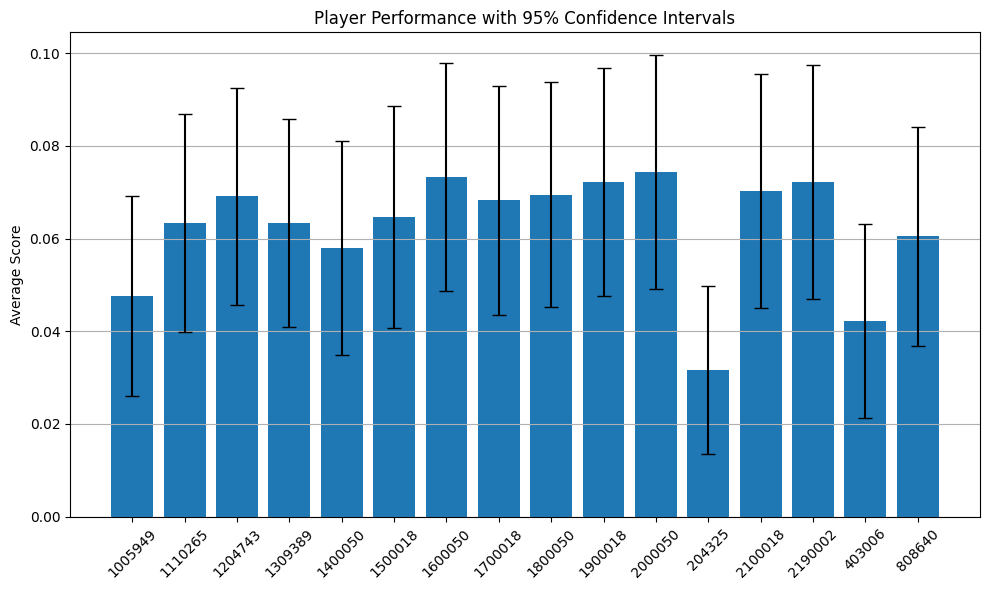

In [8]:
player_results = {}
total_results = {}
for game_result in game_results:
    for player, result in game_result:
        total_results[player] = total_results.get(player, 0) + result
        player_results[player] = player_results.get(player, []) + [result]

player_average = {}
sum_of_total_results = sum(total_results.values())
for player in total_results:
    player_average[player] = total_results[player] / sum_of_total_results

player_error_range = {}
for player in player_results:
    std = np.std(player_results[player]) / np.sqrt(len(player_results[player]))
    player_error_range[player] = 1.96 * std

plt.figure(figsize=(10, 6))

sorted_players = sorted(player_average.items(), key=lambda x: x[0])
players = [p[0] for p in sorted_players]
averages = [player_average[p] for p in players]
errors = [player_error_range[p] for p in players]

plt.bar(players, averages, yerr=errors, capsize=5)
plt.title("Player Performance with 95% Confidence Intervals")
plt.ylabel("Average Score")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [9]:
# Analyze how many different terminal states were reached.

import glob 

game_files = glob.glob("../../data/2024-12-01_10-23-12-giant-arena-for-doublehandedness/games/*")
gamedata = load_games_new(game_files)

In [39]:
terminal_board_indices = []
terminal_boards = []
for i in range(len(gamedata["game_ids"]) - 1):
    if gamedata["game_ids"][i] != gamedata["game_ids"][i + 1]:
        terminal_board_indices.append(i)
        terminal_boards.append(gamedata["boards"][i])

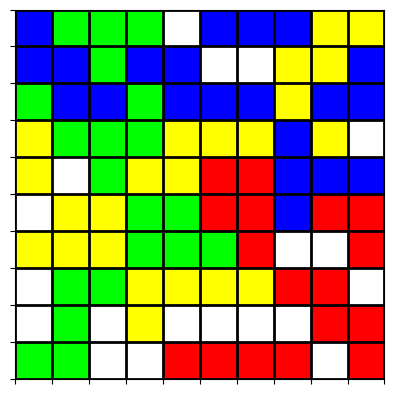

In [57]:
Display(terminal_boards[50]).show()

In [55]:
terminal_board_indices[30]

673